# 1. Create feature

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Check the directory path


In [ ]:
import os
print(len(os.listdir('./Dataset/Processed/140k/fake')))

In [ ]:
import os
print(len(os.listdir("./Dataset/Processed/faceforensics/real")))

## Prepare paths for both FaceForensics and 140k images

In [ ]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import pickle
from scipy.interpolate import griddata

def azimuthalAverage(image, center=None):
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    r_int = r_sorted.astype(int)

    deltar = r_int[1:] - r_int[:-1]
    rind = np.where(deltar)[0]
    nr = rind[1:] - rind[:-1]

    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

data= {}
epsilon = 1e-8
N = 500
y = []
error = []


number_iter = 20000

psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)
cont = 0

faceforensics = './Dataset/Processed/faceforensics'
faces140k = './Dataset/Draw/140k'


list_real_path = [f'{faceforensics}/real/{i}' for i in os.listdir(os.path.join(faceforensics, "real"))] + [f'{faces140k}/real/{i}' for i in os.listdir(os.path.join(faces140k, "real"))]
list_fake_path = [f'{faceforensics}/fake/{i}' for i in os.listdir(os.path.join(faceforensics, "fake"))] + [f'{faces140k}/fake/{i}' for i in os.listdir(os.path.join(faces140k, "fake"))]

## Feature extraction trên ảnh REAL

In [ ]:
#REAL
for filename in list_real_path:

        print('Cont: ', cont, filename)
        img = cv2.imread(filename,0)

        # we crop the center
        h = int(img.shape[0]/3)
        w = int(img.shape[1]/3)
        img = img[h:-h,w:-w]

        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)

        magnitude_spectrum = 20*np.log(np.abs(fshift))
        psd1D = azimuthalAverage(magnitude_spectrum)

        # Calculate the azimuthally averaged 1D power spectrum
        points = np.linspace(0,N,num=psd1D.size) # coordinates of a
        xi = np.linspace(0,N,num=N) # coordinates for interpolation

        interpolated = griddata(points,psd1D,xi,method='cubic')
        interpolated /= interpolated[0]

        psd1D_total[cont,:] = interpolated
        label_total[cont] = 0
        cont+=1

        if cont == number_iter:
            break

for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])


['/content/drive/MyDrive/Dataset/Processed/faceforensics/real/881_img_2.jpg', '/content/drive/MyDrive/Dataset/Processed/faceforensics/real/881_img_3.jpg', '/content/drive/MyDrive/Dataset/Processed/faceforensics/real/881_img_4.jpg', '/content/drive/MyDrive/Dataset/Processed/faceforensics/real/881_img_5.jpg', '/content/drive/MyDrive/Dataset/Processed/faceforensics/real/881_img_6.jpg', '/content/drive/MyDrive/Dataset/Processed/faceforensics/real/881_img_7.jpg', '/content/drive/MyDrive/Dataset/Processed/faceforensics/real/881_img_8.jpg', '/content/drive/MyDrive/Dataset/Processed/faceforensics/real/881_img_9.jpg', '/content/drive/MyDrive/Dataset/Processed/faceforensics/real/885_img_0.jpg', '/content/drive/MyDrive/Dataset/Processed/faceforensics/real/885_img_1.jpg', '/content/drive/MyDrive/Dataset/Processed/faceforensics/real/885_img_2.jpg', '/content/drive/MyDrive/Dataset/Processed/faceforensics/real/885_img_3.jpg', '/content/drive/MyDrive/Dataset/Processed/faceforensics/real/885_img_4.jpg'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in subtract


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Cont:  10000 /content/drive/MyDrive/Dataset/Draw/140k/real/15199.jpg
Cont:  10001 /content/drive/MyDrive/Dataset/Draw/140k/real/15201.jpg
Cont:  10002 /content/drive/MyDrive/Dataset/Draw/140k/real/15200.jpg
Cont:  10003 /content/drive/MyDrive/Dataset/Draw/140k/real/15202.jpg
Cont:  10004 /content/drive/MyDrive/Dataset/Draw/140k/real/15203.jpg
Cont:  10005 /content/drive/MyDrive/Dataset/Draw/140k/real/15205.jpg
Cont:  10006 /content/drive/MyDrive/Dataset/Draw/140k/real/15206.jpg
Cont:  10007 /content/drive/MyDrive/Dataset/Draw/140k/real/15208.jpg
Cont:  10008 /content/drive/MyDrive/Dataset/Draw/140k/real/15207.jpg
Cont:  10009 /content/drive/MyDrive/Dataset/Draw/140k/real/15210.jpg
Cont:  10010 /content/drive/MyDrive/Dataset/Draw/140k/real/15211.jpg
Cont:  10011 /content/drive/MyDrive/Dataset/Draw/140k/real/15212.jpg
Cont:  10012 /content/drive/MyDrive/Dataset/Draw/140k/real/15213.jpg
Cont:  10013 /content/drive/MyDrive/Dataset/Dr

## Perform feature extraction on FAKE images and save the features to the train.pkl file

In [ ]:
# FAKE
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)
cont = 0

for filename in list_fake_path:
        print(filename)
        print('Cont: ', cont, filename)
        img = cv2.imread(filename,0)

        h = int(img.shape[0]/3)
        w = int(img.shape[1]/3)
        img = img[h:-h,w:-w]

        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        fshift += epsilon


        magnitude_spectrum = 20*np.log(np.abs(fshift))

        psd1D = azimuthalAverage(magnitude_spectrum)

        points = np.linspace(0,N,num=psd1D.size)
        xi = np.linspace(0,N,num=N)

        interpolated = griddata(points,psd1D,xi,method='cubic')
        interpolated /= interpolated[0]

        psd1D_total2[cont,:] = interpolated
        label_total2[cont] = 1
        cont+=1

        if cont == number_iter:
            break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])


y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)

error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('/content/drive/MyDrive/Colab Notebooks/Final Project/train.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved")

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Cont:  12500 /content/drive/MyDrive/Dataset/Draw/140k/fake/658WAHF1B7.jpg
/content/drive/MyDrive/Dataset/Draw/140k/fake/65AAME6MXP.jpg
Cont:  12501 /content/drive/MyDrive/Dataset/Draw/140k/fake/65AAME6MXP.jpg
/content/drive/MyDrive/Dataset/Draw/140k/fake/65AA5A3RPG.jpg
Cont:  12502 /content/drive/MyDrive/Dataset/Draw/140k/fake/65AA5A3RPG.jpg
/content/drive/MyDrive/Dataset/Draw/140k/fake/65ALFPMVR7.jpg
Cont:  12503 /content/drive/MyDrive/Dataset/Draw/140k/fake/65ALFPMVR7.jpg
/content/drive/MyDrive/Dataset/Draw/140k/fake/65AZVVMY5Y.jpg
Cont:  12504 /content/drive/MyDrive/Dataset/Draw/140k/fake/65AZVVMY5Y.jpg
/content/drive/MyDrive/Dataset/Draw/140k/fake/65E0GQ7G4W.jpg
Cont:  12505 /content/drive/MyDrive/Dataset/Draw/140k/fake/65E0GQ7G4W.jpg
/content/drive/MyDrive/Dataset/Draw/140k/fake/65BI8F67MZ.jpg
Cont:  12506 /content/drive/MyDrive/Dataset/Draw/140k/fake/65BI8F67MZ.jpg
/content/drive/MyDrive/Dataset/Draw/140k/fake/65ESGUVL6Z.jp

In [ ]:
print(psd1D_total[0].shape)

(500,)


In [ ]:
print(len(psd1D_total_final))

30000


In [ ]:
print(len(label_total_final))

30000


In [ ]:
output = open('/content/drive/MyDrive/Colab Notebooks/Final Project/train.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved")

DATA Saved


# 2. Load features from the train.pkl file and check the number of features for each class of Real and Fake images.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# load feature file
pkl_file = open('/content/drive/MyDrive/Colab Notebooks/Final Project/train.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

We look at the label distribution, to be sure that we have a balanced dataset.

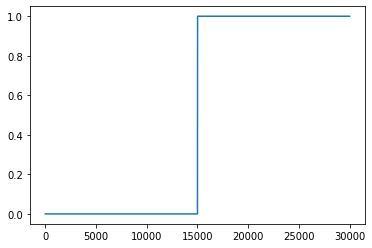

In [ ]:
plt.plot(y)

# 3. Classification

Now we classify using the features.

In [ ]:
print(len(X))

30000


## SVM and Accuracy

In [ ]:
import numpy as np
from sklearn.svm import SVC
import pickle
from sklearn.model_selection import train_test_split

#train
pkl_file = open('/content/drive/MyDrive/Colab Notebooks/Final Project/train.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

print(X[0].shape)
#Handling cases with NaN values
X = np.nan_to_num(X)
y = np.nan_to_num(y)

(500,)


In [ ]:
from sklearn.datasets import make_classification
import numpy as np
from sklearn.svm import SVC
import pickle
from sklearn.model_selection import train_test_split


# X, y = make_classification(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86)
# svclassifier_r = SVC(C=3, kernel='poly', degree=2, gamma=0.5, coef0=0.2)
svclassifier_r.fit(X_train, y_train)

SVM = svclassifier_r.score(X_test, y_test)


print("SVM: "+str(SVM))

SVM: 0.7651666666666667


## Confusion matrix

[[1619  401]
 [ 325 1655]]


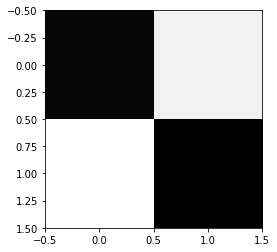

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix
# plot_confusion_matrix(SVM, X_test, y_test)
# plt.show()

pred = svclassifier_r.predict(X_test)
cm=metrics.confusion_matrix(y_test,pred)
print(cm)
plt.imshow(cm, cmap='binary')

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

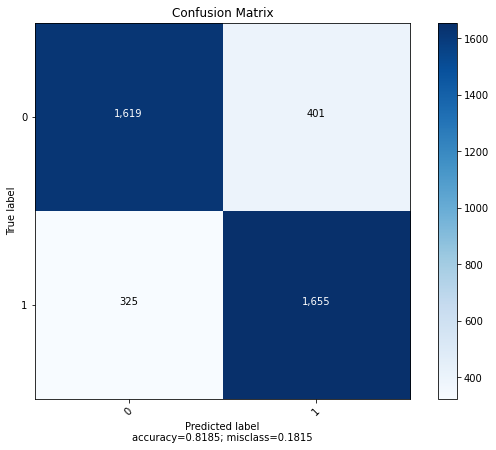

In [ ]:
plot_confusion_matrix(cm = np.array(cm),
                      normalize    = False,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix")

## Save the model after training

In [ ]:
import joblib
filename = '/content/drive/MyDrive/Colab Notebooks/Final Project/finalized_model.sav'
joblib.dump(svclassifier_r, filename)

['/content/drive/MyDrive/Colab Notebooks/Experiments_DeepFakeDetection/finalized_model.sav']

# 4. Experiment on the prepared images and videos

In [ ]:
from google.colab.patches import cv2_imshow
from scipy.interpolate import griddata

import cv2
N = 500
filename = '/content/drive/MyDrive/Dataset/Processed/faceforensics/fake/000_003_img_0.jpg'
img = cv2.imread(filename,0)

# we crop the center
h = int(img.shape[0]/3)
w = int(img.shape[1]/3)
img = img[h:-h,w:-w]

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

magnitude_spectrum = 20*np.log(np.abs(fshift))
psd1D = azimuthalAverage(magnitude_spectrum)

# Calculate the azimuthally averaged 1D power spectrum
points = np.linspace(0,N,num=psd1D.size) # coordinates of a
xi = np.linspace(0,N,num=N) # coordinates for interpolation

interpolated = griddata(points,psd1D,xi,method='cubic')
interpolated /= interpolated[0]
print(svclassifier_r.predict([interpolated]))

[1.]


In [ ]:
import joblib
path = '/content/drive/MyDrive/Colab Notebooks/Final Project/finalized_model.sav'
loaded_model = joblib.load(path)
# print(type(loaded_model.predict([interpolated])))

In [ ]:
import sys
import os
import torch
import cv2
import time
from torch import nn
import matplotlib.pyplot as plt
import matplotlib
from torchvision.transforms import Normalize
gpu = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
gpu

frames_per_video = 100
input_size = 224
test_val_frac = 0.3

sys.path.insert(0, os.path.join(root, 'Colab Notebooks', 'Final project', 'blazeface-pytorch'))
sys.path.insert(0, os.path.join(root, 'Colab Notebooks', 'Final project'))
from blazeface import BlazeFace
facedet = BlazeFace().to(gpu)

facedet.load_weights(os.path.join(root, 'Colab Notebooks', 'Final project', "blazeface.pth"))
facedet.load_anchors(os.path.join(root, 'Colab Notebooks', 'Final project', "anchors.npy"))
_ = facedet.train(False)
from helpers.read_video_1 import VideoReader
from helpers.face_extract_1 import FaceExtractor

video_reader = VideoReader(verbose=True)
video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

## Videos

In [ ]:
from scipy.interpolate import griddata

video_PATH = "/content/drive/MyDrive/Colab Notebooks/Final project/video_up/Phương tiện7.mp4"
N = 500
root = '/content/drive/MyDrive/Colab Notebooks/Final project/video_up'
list_video = os.listdir(root)
# list_video = ['Phương tiện6.mp4', 'Phương tiện7.mp4', 'Phương tiện8.mp4', 'Phương tiện9.mp4']
# list_video = ['Phương tiện7.mp4']

for path in list_video:
  label = 'Fake'
  if('[DeepFake]' in path or '[deepfake]' in path):
    label = 'Fake'
  check = 0
  faces = face_extractor.process_video(os.path.join(root, path))
  face_extractor.keep_only_best_face(faces)
  print(len(faces))
  if len(faces)>0:
      num=0
      for frame_data in faces:
        scores = frame_data['scores']
        for ind, img in enumerate(frame_data['faces']):
          if(scores[ind] > 0.9):
            img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            # cv2_imshow(img)
            h = int(img.shape[0]/3)
            w = int(img.shape[1]/3)
            img = img[h:-h,w:-w]

            f = np.fft.fft2(img)
            fshift = np.fft.fftshift(f)

            magnitude_spectrum = 20*np.log(np.abs(fshift))
            psd1D = azimuthalAverage(magnitude_spectrum)

            # Calculate the azimuthally averaged 1D power spectrum
            points = np.linspace(0,N,num=psd1D.size) # coordinates of a
            xi = np.linspace(0,N,num=N) # coordinates for interpolation

            interpolated = griddata(points,psd1D,xi,method='cubic')
            interpolated /= interpolated[0]
            if(int(loaded_model.predict([interpolated]))):
              check -=1
            else: check +=1
  pred = 'Real'
  if(check < 0):
    pred = 'Fake'
  print(path , 'Label: ', label, "Pred: ", pred)

100
The Office- Asian Jim [DeepFake].mp4 Label:  Fake Pred:  Fake
100
Jim Carrey as Joker [deepfake].mp4 Label:  Fake Pred:  Real
100
The Shining starring Jim Carrey - Episode 2 - The Bat [DeepFake].mp4 Label:  Fake Pred:  Fake
100
Wiz Khalifa - See You Again ft. Charlie Puth [Official Video] Furious 7 Soundtrack.mp4 Label:  Fake Pred:  Fake
100
Neo Takes The Blue Pill [DeepFake] (1).mp4 Label:  Fake Pred:  Fake
100
Artists create Zuckerberg _deepfake_ video.mp4 Label:  Fake Pred:  Real
100
Donald Trump is Fat Bastard! (DeepFake).mp4 Label:  Fake Pred:  Fake
100
Chris Bumstead vs Breon Ansley - -They Are Fighting For 2nd Place- - 2021 Mr. Olympia.mp4 Label:  Fake Pred:  Fake
100
Jim Carrey Walks Into A Bar [DeepFake].mp4 Label:  Fake Pred:  Fake
100
Better Call Trump- Money Laundering 101 [DeepFake].mp4 Label:  Fake Pred:  Fake
100
Hôm Nay Em Cưới Rồi - Khải Đăng - Official MV- Đàm Vĩnh Hưng, Vũ Hà, Ribi Sachi, Pom, Jay Quân.mp4 Label:  Fake Pred:  Fake
100
Chúng Ta Khô